# Unamortised VAE test

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../experiments/")
import base_vae_hardem

In [3]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_VISIBLE_DEVICES"] = "1"

In [4]:
import jax
import hlax
import tomli
import distrax
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from tqdm.notebook import tqdm

In [5]:
%config InlineBackend.figure_format = "retina"

In [6]:
def build_mll_summary(res, procedure):
    df_mll = pd.DataFrame(res["test"]["hist_loss"]).melt(var_name="episode", value_name="mll")
    df_mll["procedure"] = procedure

    df_times = pd.DataFrame.from_dict({"times": res["train"]["times"]}, orient="index").T
    df_mll = pd.merge(df_mll, df_times, left_on="episode", right_index=True)
    return df_mll

## Loss functions

In [7]:
def iwae_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder and Gaussian encoder
    """
    batch_size = len(X_batch)

    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z[None, ...], std_z[None, ...])

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=(-1, -2, -3))
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x - log_prob_z_post

    niwmll = jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples).mean()
    return niwmll


def iwae_bern_delta(key, params, apply_fn, X_batch):
    encode_decode = apply_fn(params, X_batch, key)
    z_batch, logit_mean_x = encode_decode
    _, dim_latent = z_batch.shape
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    
    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

## Models

In [8]:
from typing import Callable, List

class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    dim_full: int
    dim_latent: int = 20
    
    def setup(self):
        self.logit = nn.Dense(self.dim_full, use_bias=False, name="mean")
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(30)(z)
        x = nn.elu(x)
        logit_x = self.logit(x)
        return logit_x


class Encoder(nn.Module):
    """
    two-layered encoder
    """
    dim_latent: int
    n_hidden: int = 50
    normal_init: Callable = nn.initializers.normal()
    
    def setup(self):
        ...
        # self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.tanh(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.tanh(z)
        mean_z = nn.Dense(self.dim_latent)(z)
        logvar_z = nn.Dense(self.dim_latent, use_bias=False)(z)
        # logvar_z = self.logvar_diag
        return mean_z, logvar_z
    


class ConvEncoder(nn.Module):
    latent_dim: List

    @nn.compact
    def __call__(self, x):
        z = nn.Conv(5, (3, 3), padding="SAME")(x)
        z = nn.elu(z)
        z = nn.max_pool(z, (2, 2), padding="SAME")
        z = z.reshape((z.shape[0], -1))
        z = nn.Dense(self.latent_dim)(z)

        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z


class ConvDecoder(nn.Module):
    dim_obs: List
    dim_latent: int

    @nn.compact
    def __call__(self, z):
        x = nn.Dense(28 ** 2)(z)
        x = x.reshape(*z.shape[:-1], *(28, 28, 1))
        x = nn.elu(x)
        x = nn.Conv(5, (3, 3), padding="SAME")(x)
        x = nn.elu(x)
        x = nn.Conv(1, (3, 3), padding="SAME")(x)
        return x    

    
    
class GaussEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.mu = self.param("mu", self.normal_init, (self.dim_latent,))
        # self.mu = nn.Dense(self.dim_latent)
        self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))

    def __call__(self, x):
        """
        Input x (_) is a dummy variable
        """
        # z = self.mu(x)
        z = self.mu
        return z, self.logvar_diag

    
class UnamortisedVAEBernDelta(nn.Module):
    """
    Base class for an unamortised variational autoencoder
    with Bernoulli decoder p(x|z) = Bern(x| f(z))
    and Dirac-delta encoder q(z|x) = delta(z = z^)
    """
    latent_dim: int
    obs_dim: int
    Encoder: nn.Module
    Decoder: nn.Module

    def setup(self):
        self.encoder = nn.vmap(
            self.Encoder,
            variable_axes={"params": 0},
            split_rngs={"params": True},
            in_axes=0,
        )(self.latent_dim)
        self.decoder = self.Decoder(self.obs_dim, self.latent_dim)

    def __call__(self, x, key_eps, num_samples=1):
        z = self.encoder(x)
        logit_mean_x = self.decoder(z)
        return z, logit_mean_x


class DeltaEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.z = self.param("z", self.normal_init, (self.dim_latent,))

    def __call__(self, _):
        """
        Input x (_) is a dummy variable
        """
        return self.z

## Setup

In [9]:
batch_size = 200
key = jax.random.PRNGKey(314)
warmup, test = hlax.datasets.load_fashion_mnist(n_train=5_000, n_test=100, normalize=False, melt=False)
X_warmup = warmup[0][..., None].round()
X_test = test[0][..., None].round()

In [195]:
dim_latent = 50
num_obs, *dim_obs = X_warmup.shape

In [196]:
path_config = "../experiments/configs/fmnist-conv01.toml"
with open(path_config, "rb") as f:
    config_str = f.read().decode("utf-8")
    config = tomli.loads(config_str)

print(config_str)

# TOML file for a fashion mnist dataset
[setup]
dim_latent = 50

[train]
    num_obs = 10_000
    num_epochs = 3000
    batch_size = 200
    eval_epochs = [2, 10, 100, 250, 500, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500, 3000]
    learning_rate = 1e-6 # For VAE and HardEM

    [train.vae]
        num_is_samples = 10
    [train.hard_em]
        num_its_latent = 10 # E-step
        num_its_params = 5 # M-step

[test]
    batch_size = 100
    num_obs = 1000
    num_epochs = 500
    learning_rate = 1e-6
    num_is_samples = 10
    num_e_steps = 5
    num_m_steps = 0


In [212]:
config["train"]["learning_rate"] = 1e-5
config["train"]["hard_em"]["num_its_latent"] = 20
config["train"]["hard_em"]["num_its_params"] = 1
config["train"]["num_epochs"] = 100
config["train"]["vae"]["num_is_samples"] = 5

step = 2
config["train"]["eval_epochs"] = [1] + list(range(0, 100 + step, step))[1:]

config["test"]["learning_rate"] = 1e-2
config["test"]["num_epochs"] = 1000
config["test"]["num_e_steps"] = 1
config["test"]["num_m_steps"] = 0
config["test"]["num_is_samples"] = 1

In [213]:
model_decoder = Decoder(28 ** 2, dim_latent)

In [214]:
model_test = hlax.models.UnamortisedVAEBern(dim_latent, dim_obs[0], GaussEncoder, ConvDecoder)
config_test = hlax.unamortised.load_test_config(config, model_test)

## Benchmark models

In [215]:
def iwae_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder and Gaussian encoder
    """
    batch_size = len(X_batch)

    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z, std_z)

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=(-1, -2, -3))
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x - log_prob_z_post

    niwmll = jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples).mean()
    return niwmll


def elbo_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder and Gaussian encoder
    """
    batch_size = len(X_batch)

    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)
    var_z = jnp.exp(logvar_z)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z, std_z)

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=(-1, -2, -3))
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)
    
    
    loss = (1 + logvar_z - mean_z ** 2 - var_z).sum(axis=-1) / 2 + log_prob_x.mean(axis=0)
    return -loss.mean()



def iwae_bern_delta(key, params, apply_fn, X_batch):
    encode_decode = apply_fn(params, X_batch, key)
    z_batch, logit_mean_x = encode_decode
    _, dim_latent = z_batch.shape
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    
    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=(-1, -2, -3))

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

### VAE

In [ ]:
%%time
model_vae = hlax.models.VAEBern(dim_latent, dim_obs, ConvEncoder, ConvDecoder)
config_vae = hlax.vae.load_config(config, model_vae)

res_vae = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_vae,
    config_test,
    elbo_bern,
    elbo_bern,
    hlax.vae.train_checkpoints
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
ix_epoch = "e100"

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ix_target = 9
params_test = res_vae["test"]["state"][ix_epoch].params
img_truth = X_test[ix_target].reshape(28, 28)
img_reconstruct = config_test.model.apply(params_test, X_test, key)[2][0]
img_reconstruct = nn.sigmoid(img_reconstruct[ix_target]).reshape(28, 28)

ax[0].imshow(img_truth, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");
plt.tight_layout()

### Hard-EM unamortised

In [ ]:
%%time
model_hem = UnamortisedVAEBernDelta(dim_latent, dim_obs[0], DeltaEncoder, ConvDecoder)
config_hem = hlax.unamortised.load_config(config, model_hem)

res_hem = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_hem,
    config_test,
    iwae_bern_delta,
    elbo_bern,
    hlax.unamortised.train_checkpoints
)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ix_target = 9
params_test = res_hem["test"]["state"][ix_epoch].params
img_truth = X_test[ix_target].reshape(28, 28)
img_reconstruct = config_test.model.apply(params_test, X_test, key)[2][0]
img_reconstruct = nn.sigmoid(img_reconstruct[ix_target]).reshape(28, 28)

ax[0].imshow(img_truth, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");

### Umamortised VAE

In [ ]:
%%time
model_uvae = hlax.models.UnamortisedVAEBern(dim_latent, dim_obs[0], GaussEncoder, ConvDecoder)
config_uvae = hlax.unamortised.load_config(config, model_uvae)

res_uvae = base_vae_hardem.train_test(
    key,
    X_warmup,
    X_test,
    config_uvae,
    config_test,
    elbo_bern,
    elbo_bern,
    hlax.unamortised.train_checkpoints
)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ix_target = 9

params_test = res_uvae["test"]["state"][ix_epoch].params
img_truth = X_test[ix_target].reshape(28, 28)
img_reconstruct = config_test.model.apply(params_test, X_test, key)[2][0]
img_reconstruct = nn.sigmoid(img_reconstruct[ix_target]).reshape(28, 28)

ax[0].imshow(img_truth, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");

In [ ]:
fig, ax = plt.subplots(1, 4)

ix_target = 9
img_truth = X_test[ix_target]
ax[0].imshow(img_truth, cmap="cividis")
ax[0].set_title("original")
ax[0].axis("off")

res_list = [res_hem, res_vae, res_uvae]
labels = ["HEM", "VAE", "uVAE"]
for i, (res, label) in enumerate(zip(res_list, labels)):
    params_test = res["test"]["state"][ix_epoch].params
    img_reconstruct = config_test.model.apply(params_test, X_test, key)[2][0]
    img_reconstruct = nn.sigmoid(img_reconstruct[ix_target])
    ax[i + 1].imshow(img_reconstruct, cmap="cividis")
    ax[i + 1].axis("off")
    ax[i + 1].set_title(label)
plt.tight_layout()

In [ ]:
plt.plot(res_hem["test"]["hist_loss"][ix_epoch])
plt.plot(res_vae["test"]["hist_loss"][ix_epoch])
plt.plot(res_uvae["test"]["hist_loss"][ix_epoch])

## Observe training results

In [ ]:
ix_target = 5
res = res_hem
model = model_hem

state_final = res["train"]["state_final"]
params= state_final.params
vals = model.apply(params, X_warmup, key)[1]# [-1][0]

img_reconstruct = vals[ix_target].reshape(28, 28)
img_reconstruct = nn.sigmoid(img_reconstruct)

img_target = X_warmup[ix_target].reshape(28, 28)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img_target, cmap="cividis")
ax[1].imshow(img_reconstruct, cmap="cividis")

ax[0].axis("off")
ax[1].axis("off");

In [ ]:
apply_fn = partial(config_test.model.apply, num_samples=10)

In [ ]:
num_samples = 100
keys_eval = jax.random.split(key, num_samples)
vmap_iwae = jax.vmap(iwae_bern, (0, None, None, None))

res_list = [res_hem, res_vae, res_uvae]
labels = ["HEM", "VAE", "uVAE"]

df_mll = []
elements = list(zip(res_list, labels))
for res, label in tqdm(elements):
    for ix_epoch in res["test"]["state"]:
        state_test = res["test"]["state"][ix_epoch]
        params_test = state_test.params
        is_mll = vmap_iwae(keys_eval, params_test, apply_fn, X_test)

        entry = {
            "label": label,
            "mll": is_mll.to_py(),
            "epoch": int(ix_epoch.lstrip("e"))
        }

        df_mll.append(entry)
df_mll = pd.DataFrame(df_mll).explode("mll")

In [ ]:
mll_std = df_mll.pivot_table(index="epoch", columns="label", values="mll", aggfunc="std")
mll_mean = df_mll.pivot_table(index="epoch", columns="label", values="mll", aggfunc="mean")

fig, ax = plt.subplots(figsize=(8, 4))
xvals = mll_mean.index
for col in mll_mean:
    mean = mll_mean[col]
    std = mll_std[col]
    
    plt.fill_between(xvals, mean - 2 * std, mean + 2 * std, alpha=0.5)
    plt.plot(xvals, mean, label=col)
    
plt.legend()
plt.title("(IW) Marginal log-likelihood")
plt.xticks(rotation=45)
plt.grid(alpha=0.5)

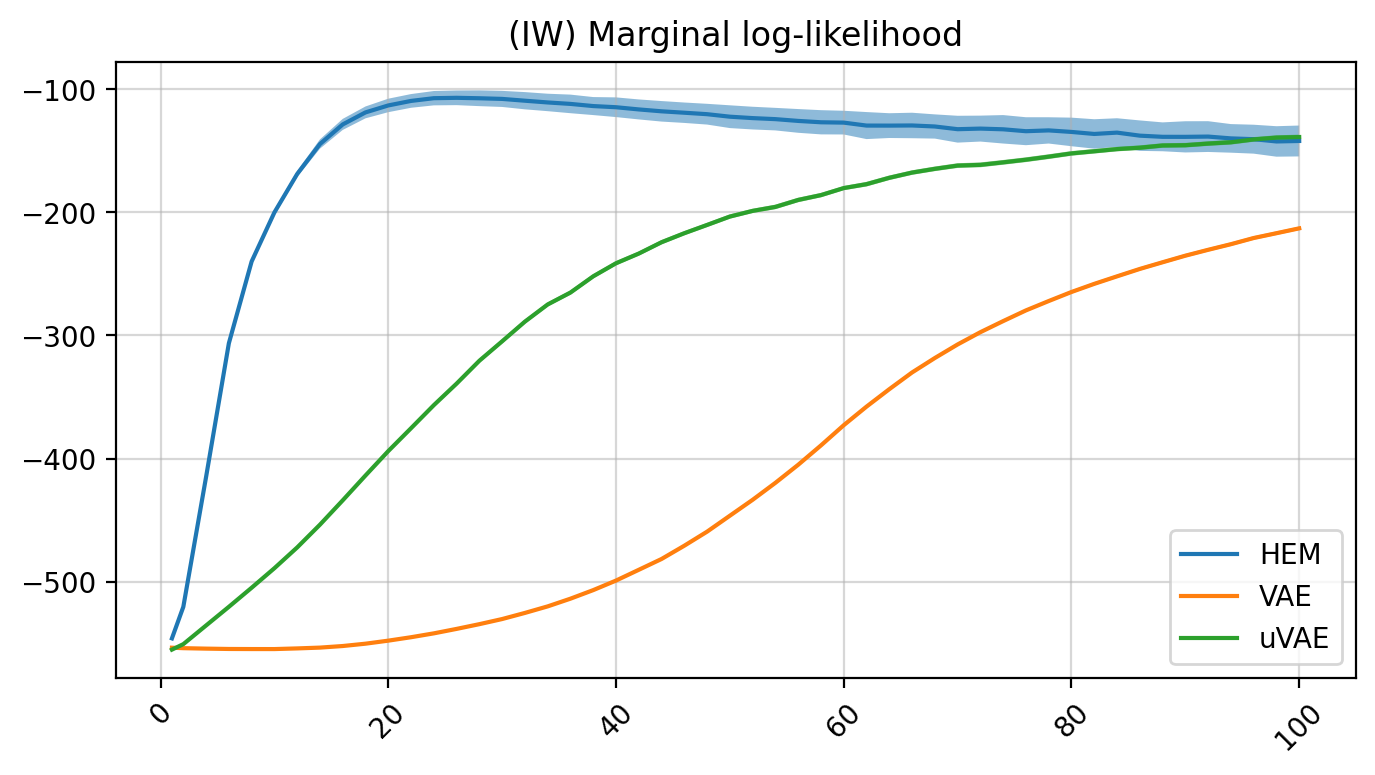

In [172]:
mll_std = df_mll.pivot_table(index="epoch", columns="label", values="mll", aggfunc="std")
mll_mean = df_mll.pivot_table(index="epoch", columns="label", values="mll", aggfunc="mean")

fig, ax = plt.subplots(figsize=(8, 4))
xvals = mll_mean.index
for col in mll_mean:
    mean = mll_mean[col]
    std = mll_std[col]
    
    plt.fill_between(xvals, mean - 2 * std, mean + 2 * std, alpha=0.5)
    plt.plot(xvals, mean, label=col)
    
plt.legend()
plt.title("(IW) Marginal log-likelihood")
plt.xlabel("Epoch")
plt.xticks(rotation=45)
plt.grid(alpha=0.5)